In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, mean_squared_error, r2_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, LSTM, SimpleRNN, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import mixed_precision

In [22]:
# 1. Load and preprocess dataset
df = pd.read_csv('DATASET_FINAL_NO_STOPWORDS.csv')

In [23]:
# Assume columns: 'text', 'label'
texts = df['Sentiment'].astype(str).tolist()
labels = df['Label'].astype(str).tolist()

In [24]:
# Encode labels
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
y = np.array([label_to_index[label] for label in labels])
num_classes = len(label_to_index)
y_cat = to_categorical(y, num_classes=num_classes)

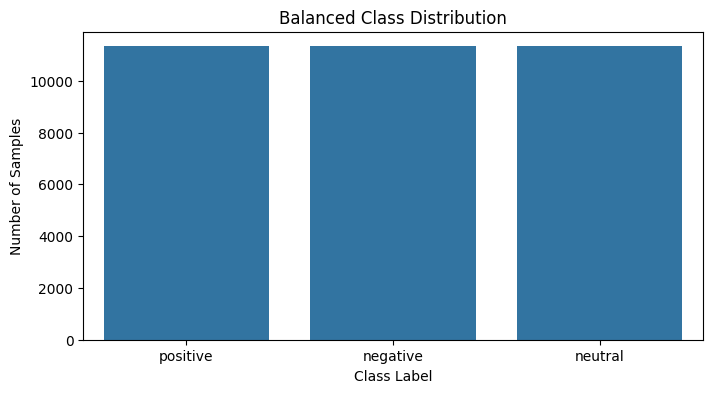

In [ ]:
# Use calculated class weights based on dataset distribution
class_weights = {
    0: 1.185,  # positive
    1: 1.789,  # negative
    2: 0.626   # neutral
}
print('Class weights:', class_weights)

# Visualize original class distribution (no upsampling)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.countplot(x=labels)
plt.title('Original Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.show()

print(f"Original dataset size: {len(texts)} samples")
print("Class distribution:")
unique_labels, counts = np.unique(labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"  {label}: {count} samples")

In [26]:
# Re-encode labels after balancing
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
y = np.array([label_to_index[label] for label in labels])
num_classes = len(label_to_index)
y_cat = to_categorical(y, num_classes=num_classes)

In [27]:
# 2. Tokenization and Embedding
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
maxlen = 100
X = pad_sequences(sequences, maxlen=maxlen)

In [28]:
# 3. K-Fold Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [29]:
# Regularization strength
l2_reg = regularizers.l2(1e-3)

# CNN for sentiment
def build_cnn(input_length, vocab_size, num_classes):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=128, input_length=input_length),
        Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=l2_reg),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu', kernel_regularizer=l2_reg),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax', dtype='float32')  # softmax in float32
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Simple RNN
def build_rnn(input_length, vocab_size, num_classes):
    model = Sequential([
        Embedding(vocab_size, 128, input_length=input_length),
        SimpleRNN(64, kernel_regularizer=l2_reg, return_sequences=False),
        Dense(64, activation='relu', kernel_regularizer=l2_reg),
        BatchNormalization(),
        Dropout(0.4),
        Dense(num_classes, activation='softmax', dtype='float32')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# LSTM
def build_lstm(input_length, vocab_size, num_classes):
    model = Sequential([
        Embedding(vocab_size, 128, input_length=input_length),
        LSTM(64, kernel_regularizer=l2_reg, return_sequences=False),
        Dense(64, activation='relu', kernel_regularizer=l2_reg),
        BatchNormalization(),
        Dropout(0.4),
        Dense(num_classes, activation='softmax', dtype='float32')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
# Enable mixed precision for faster training on A5000
policy = mixed_precision.Policy("mixed_float16")
mixed_precision.set_global_policy(policy)

# Callbacks: stop early & reduce LR if plateau
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
]

# Use the class weights defined earlier (Positive=2, Negative=2, Neutral=1)
# class_weights is already defined in the previous cell

results = {'CNN': [], 'RNN': [], 'LSTM': []}
train_histories = {'CNN': [], 'RNN': [], 'LSTM': []}

for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
    print(f"\n===== Fold {fold+1} =====")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]  # Use sparse labels for sparse_categorical_crossentropy
    y_val_labels = y[val_idx]
    vocab_size = min(10000, len(tokenizer.word_index) + 1) + 1

    for name, build_fn in zip(['CNN', 'RNN', 'LSTM'], [build_cnn, build_rnn, build_lstm]):
        print(f"Training {name} on Fold {fold+1}...")

        model = build_fn(maxlen, vocab_size, num_classes)

        history = model.fit(
            X_train, y_train,
            epochs=5,
            batch_size=128,
            validation_data=(X_val, y_val),
            class_weight=class_weights,
            verbose=1,
            callbacks=callbacks
        )

        # Track training history
        train_histories[name].append(history)

        # Predictions
        y_pred_prob = model.predict(X_val, batch_size=512, verbose=0)
        y_pred = np.argmax(y_pred_prob, axis=1)

        # Metrics
        acc = accuracy_score(y_val_labels, y_pred)
        prec = precision_score(y_val_labels, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_val_labels, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_val_labels, y_pred, average='weighted', zero_division=0)
        mcc = matthews_corrcoef(y_val_labels, y_pred)
        mse = mean_squared_error(y_val_labels, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_val_labels, y_pred)

        results[name].append({
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'mcc': mcc,
            'mse': mse,
            'rmse': rmse,
            'r2': r2
        })

        print(f"{name} Fold {fold+1}: "
              f"Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, "
              f"F1={f1:.4f}, MCC={mcc:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")

print("\n=== Cross-Validation Results ===")
for model_name, fold_results in results.items():
    avg_acc = np.mean([r['accuracy'] for r in fold_results])
    avg_prec = np.mean([r['precision'] for r in fold_results])
    avg_rec = np.mean([r['recall'] for r in fold_results])
    avg_f1 = np.mean([r['f1'] for r in fold_results])
    avg_mcc = np.mean([r['mcc'] for r in fold_results])
    avg_mse = np.mean([r['mse'] for r in fold_results])
    avg_rmse = np.mean([r['rmse'] for r in fold_results])
    avg_r2 = np.mean([r['r2'] for r in fold_results])

    print(f"\n{model_name} - Average Results:")
    print(f"  Accuracy: {avg_acc:.4f} (±{np.std([r['accuracy'] for r in fold_results]):.4f})")
    print(f"  Precision: {avg_prec:.4f} (±{np.std([r['precision'] for r in fold_results]):.4f})")
    print(f"  Recall: {avg_rec:.4f} (±{np.std([r['recall'] for r in fold_results]):.4f})")
    print(f"  F1-score: {avg_f1:.4f} (±{np.std([r['f1'] for r in fold_results]):.4f})")
    print(f"  MCC: {avg_mcc:.4f} (±{np.std([r['mcc'] for r in fold_results]):.4f})")
    print(f"  MSE: {avg_mse:.4f} (±{np.std([r['mse'] for r in fold_results]):.4f})")
    print(f"  RMSE: {avg_rmse:.4f} (±{np.std([r['rmse'] for r in fold_results]):.4f})")
    print(f"  R²: {avg_r2:.4f} (±{np.std([r['r2'] for r in fold_results]):.4f})")


===== Fold 1 =====
Training CNN on Fold 1...
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


213/213 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.5374 - loss: 1.2482 - val_accuracy: 0.4857 - val_loss: 1.1142 - learning_rate: 0.0010
Epoch 2/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8476 - loss: 0.5406 - val_accuracy: 0.8292 - val_loss: 0.6928 - learning_rate: 0.0010
Epoch 3/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9067 - loss: 0.3796 - val_accuracy: 0.8663 - val_loss: 0.4680 - learning_rate: 0.0010
Epoch 4/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9273 - loss: 0.3192 - val_accuracy: 0.8495 - val_loss: 0.5418 - learning_rate: 0.0010
Epoch 5/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9374 - loss: 0.2666 - val_accuracy: 0.8548 - val_loss: 0.5017 - learning_rate: 0.0010
CNN Fold 1: Acc=0.8663, Prec=0.8674, Rec=0.8663, F1=0.8665, MCC=0.7997, RMSE=0.4180, R2=0.7391
Training RNN on Fold 1...
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


213/213 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.5025 - loss: 1.3321 - val_accuracy: 0.7273 - val_loss: 0.9142 - learning_rate: 0.0010
Epoch 2/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8274 - loss: 0.5693 - val_accuracy: 0.4929 - val_loss: 2.1208 - learning_rate: 0.0010
Epoch 3/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8864 - loss: 0.4119 - val_accuracy: 0.8461 - val_loss: 0.5627 - learning_rate: 0.0010
Epoch 4/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9130 - loss: 0.3242 - val_accuracy: 0.7807 - val_loss: 0.8418 - learning_rate: 0.0010
Epoch 5/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9246 - loss: 0.2872 - val_accuracy: 0.7087 - val_loss: 1.2077 - learning_rate: 0.0010
RNN Fold 1: Acc=0.8461, Prec=0.8534, Rec=0.8461, F1=0.8470, MCC=0.7719, RMSE=0.4435, R2=0.7064
Training LSTM on Fold 1...
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


213/213 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.5466 - loss: 1.1541 - val_accuracy: 0.4197 - val_loss: 1.0979 - learning_rate: 0.0010
Epoch 2/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7960 - loss: 0.5844 - val_accuracy: 0.6873 - val_loss: 0.7801 - learning_rate: 0.0010
Epoch 3/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8398 - loss: 0.4637 - val_accuracy: 0.7635 - val_loss: 0.6339 - learning_rate: 0.0010
Epoch 4/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8637 - loss: 0.3950 - val_accuracy: 0.7652 - val_loss: 0.6894 - learning_rate: 0.0010
Epoch 5/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8769 - loss: 0.3481 - val_accuracy: 0.8254 - val_loss: 0.5338 - learning_rate: 0.0010
LSTM Fold 1: Acc=0.8254, Prec=0.8255, Rec=0.8254, F1=0.8218, MCC=0.7411, RMSE=0.5023, R2=0.6234

===== Fold 2 =====
Training CNN on Fold 2...
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


213/213 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5333 - loss: 1.2448 - val_accuracy: 0.4237 - val_loss: 1.1330 - learning_rate: 0.0010
Epoch 2/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8420 - loss: 0.5509 - val_accuracy: 0.7768 - val_loss: 0.7143 - learning_rate: 0.0010
Epoch 3/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9065 - loss: 0.3701 - val_accuracy: 0.8376 - val_loss: 0.5630 - learning_rate: 0.0010
Epoch 4/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9317 - loss: 0.2964 - val_accuracy: 0.8742 - val_loss: 0.4786 - learning_rate: 0.0010
Epoch 5/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9421 - loss: 0.2581 - val_accuracy: 0.8776 - val_loss: 0.4577 - learning_rate: 0.0010
CNN Fold 2: Acc=0.8776, Prec=0.8794, Rec=0.8776, F1=0.8776, MCC=0.8172, RMSE=0.3943, R2=0.7649
Training RNN on Fold 2...
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


213/213 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.4930 - loss: 1.3589 - val_accuracy: 0.3651 - val_loss: 1.2684 - learning_rate: 0.0010
Epoch 2/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8138 - loss: 0.5932 - val_accuracy: 0.7296 - val_loss: 0.7984 - learning_rate: 0.0010
Epoch 3/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8792 - loss: 0.4212 - val_accuracy: 0.8002 - val_loss: 0.7382 - learning_rate: 0.0010
Epoch 4/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9105 - loss: 0.3357 - val_accuracy: 0.7718 - val_loss: 0.8414 - learning_rate: 0.0010
Epoch 5/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9249 - loss: 0.2843 - val_accuracy: 0.5547 - val_loss: 1.9022 - learning_rate: 0.0010
RNN Fold 2: Acc=0.8002, Prec=0.8210, Rec=0.8002, F1=0.7975, MCC=0.7139, RMSE=0.5870, R2=0.4791
Training LSTM on Fold 2...
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


213/213 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.5548 - loss: 1.1507 - val_accuracy: 0.3597 - val_loss: 1.1179 - learning_rate: 0.0010
Epoch 2/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7993 - loss: 0.5713 - val_accuracy: 0.5025 - val_loss: 0.9139 - learning_rate: 0.0010
Epoch 3/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8322 - loss: 0.4621 - val_accuracy: 0.8302 - val_loss: 0.4880 - learning_rate: 0.0010
Epoch 4/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8613 - loss: 0.3923 - val_accuracy: 0.8029 - val_loss: 0.5615 - learning_rate: 0.0010
Epoch 5/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8834 - loss: 0.3275 - val_accuracy: 0.8085 - val_loss: 0.5645 - learning_rate: 0.0010
LSTM Fold 2: Acc=0.8302, Prec=0.8298, Rec=0.8302, F1=0.8298, MCC=0.7455, RMSE=0.4816, R2=0.6492

===== Fold 3 =====
Training CNN on Fold 3...
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


213/213 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.5339 - loss: 1.2445 - val_accuracy: 0.3528 - val_loss: 1.1987 - learning_rate: 0.0010
Epoch 2/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8534 - loss: 0.5454 - val_accuracy: 0.7693 - val_loss: 0.7280 - learning_rate: 0.0010
Epoch 3/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9051 - loss: 0.3926 - val_accuracy: 0.8348 - val_loss: 0.5470 - learning_rate: 0.0010
Epoch 4/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9287 - loss: 0.3069 - val_accuracy: 0.8708 - val_loss: 0.4877 - learning_rate: 0.0010
Epoch 5/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9412 - loss: 0.2667 - val_accuracy: 0.8620 - val_loss: 0.5232 - learning_rate: 0.0010
CNN Fold 3: Acc=0.8708, Prec=0.8717, Rec=0.8708, F1=0.8706, MCC=0.8069, RMSE=0.4283, R2=0.7260
Training RNN on Fold 3...
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


213/213 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.4913 - loss: 1.3333 - val_accuracy: 0.6761 - val_loss: 0.9262 - learning_rate: 0.0010
Epoch 2/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8156 - loss: 0.5875 - val_accuracy: 0.3320 - val_loss: 3.8416 - learning_rate: 0.0010
Epoch 3/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8761 - loss: 0.4244 - val_accuracy: 0.6726 - val_loss: 1.1082 - learning_rate: 0.0010
Epoch 4/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9122 - loss: 0.3191 - val_accuracy: 0.7401 - val_loss: 0.8923 - learning_rate: 5.0000e-04
Epoch 5/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9286 - loss: 0.2746 - val_accuracy: 0.5669 - val_loss: 1.7647 - learning_rate: 5.0000e-04
RNN Fold 3: Acc=0.7401, Prec=0.7941, Rec=0.7401, F1=0.7336, MCC=0.6321, RMSE=0.6448, R2=0.3790
Training LSTM on Fold 3...
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


213/213 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.5600 - loss: 1.1530 - val_accuracy: 0.3981 - val_loss: 1.1402 - learning_rate: 0.0010
Epoch 2/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8026 - loss: 0.5838 - val_accuracy: 0.6778 - val_loss: 0.7794 - learning_rate: 0.0010
Epoch 3/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8397 - loss: 0.4702 - val_accuracy: 0.7933 - val_loss: 0.5636 - learning_rate: 0.0010
Epoch 4/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8640 - loss: 0.3931 - val_accuracy: 0.8088 - val_loss: 0.5562 - learning_rate: 0.0010
Epoch 5/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8827 - loss: 0.3407 - val_accuracy: 0.8036 - val_loss: 0.6004 - learning_rate: 0.0010
LSTM Fold 3: Acc=0.8088, Prec=0.8302, Rec=0.8088, F1=0.8068, MCC=0.7238, RMSE=0.5139, R2=0.6056

===== Fold 4 =====
Training CNN on Fold 4...
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


213/213 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.5377 - loss: 1.2472 - val_accuracy: 0.4590 - val_loss: 1.1270 - learning_rate: 0.0010
Epoch 2/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8500 - loss: 0.5461 - val_accuracy: 0.7724 - val_loss: 0.7259 - learning_rate: 0.0010
Epoch 3/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9101 - loss: 0.3786 - val_accuracy: 0.8335 - val_loss: 0.5492 - learning_rate: 0.0010
Epoch 4/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9315 - loss: 0.3031 - val_accuracy: 0.8492 - val_loss: 0.5505 - learning_rate: 0.0010
Epoch 5/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9406 - loss: 0.2667 - val_accuracy: 0.8604 - val_loss: 0.4981 - learning_rate: 0.0010
CNN Fold 4: Acc=0.8604, Prec=0.8604, Rec=0.8604, F1=0.8594, MCC=0.7914, RMSE=0.4433, R2=0.7088
Training RNN on Fold 4...
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


213/213 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.5031 - loss: 1.2781 - val_accuracy: 0.7749 - val_loss: 0.9186 - learning_rate: 0.0010
Epoch 2/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8206 - loss: 0.5616 - val_accuracy: 0.6849 - val_loss: 0.8519 - learning_rate: 0.0010
Epoch 3/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8830 - loss: 0.4028 - val_accuracy: 0.6596 - val_loss: 1.2678 - learning_rate: 0.0010
Epoch 4/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9114 - loss: 0.3151 - val_accuracy: 0.7501 - val_loss: 0.8629 - learning_rate: 0.0010
Epoch 5/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9257 - loss: 0.2605 - val_accuracy: 0.8307 - val_loss: 0.6377 - learning_rate: 5.0000e-04
RNN Fold 4: Acc=0.8307, Prec=0.8396, Rec=0.8307, F1=0.8325, MCC=0.7483, RMSE=0.5097, R2=0.6151
Training LSTM on Fold 4...
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


213/213 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5598 - loss: 1.1554 - val_accuracy: 0.3573 - val_loss: 1.1650 - learning_rate: 0.0010
Epoch 2/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8097 - loss: 0.5696 - val_accuracy: 0.7196 - val_loss: 0.7365 - learning_rate: 0.0010
Epoch 3/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8434 - loss: 0.4565 - val_accuracy: 0.8019 - val_loss: 0.5543 - learning_rate: 0.0010
Epoch 4/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8724 - loss: 0.3780 - val_accuracy: 0.8220 - val_loss: 0.5252 - learning_rate: 0.0010
Epoch 5/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8844 - loss: 0.3430 - val_accuracy: 0.8174 - val_loss: 0.5670 - learning_rate: 0.0010
LSTM Fold 4: Acc=0.8220, Prec=0.8317, Rec=0.8220, F1=0.8229, MCC=0.7368, RMSE=0.4815, R2=0.6565

===== Fold 5 =====
Training CNN on Fold 5...
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


213/213 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.5333 - loss: 1.2205 - val_accuracy: 0.5406 - val_loss: 1.0701 - learning_rate: 0.0010
Epoch 2/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8486 - loss: 0.5472 - val_accuracy: 0.7460 - val_loss: 0.7244 - learning_rate: 0.0010
Epoch 3/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9082 - loss: 0.3735 - val_accuracy: 0.8579 - val_loss: 0.4890 - learning_rate: 0.0010
Epoch 4/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9322 - loss: 0.2951 - val_accuracy: 0.8432 - val_loss: 0.5666 - learning_rate: 0.0010
Epoch 5/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9403 - loss: 0.2588 - val_accuracy: 0.8517 - val_loss: 0.5726 - learning_rate: 0.0010
CNN Fold 5: Acc=0.8579, Prec=0.8647, Rec=0.8579, F1=0.8585, MCC=0.7892, RMSE=0.4186, R2=0.7336
Training RNN on Fold 5...
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


213/213 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.4861 - loss: 1.3347 - val_accuracy: 0.5883 - val_loss: 1.0172 - learning_rate: 0.0010
Epoch 2/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8174 - loss: 0.5762 - val_accuracy: 0.7323 - val_loss: 0.6968 - learning_rate: 0.0010
Epoch 3/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8811 - loss: 0.4105 - val_accuracy: 0.6002 - val_loss: 2.5110 - learning_rate: 0.0010
Epoch 4/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9084 - loss: 0.3350 - val_accuracy: 0.4054 - val_loss: 4.2771 - learning_rate: 0.0010
Epoch 5/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9261 - loss: 0.2687 - val_accuracy: 0.8461 - val_loss: 0.5969 - learning_rate: 5.0000e-04
RNN Fold 5: Acc=0.8461, Prec=0.8495, Rec=0.8461, F1=0.8472, MCC=0.7696, RMSE=0.4528, R2=0.6882
Training LSTM on Fold 5...
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5598 - loss: 1.1452 - val_accuracy: 0.3758 - val_loss: 1.1123 - learning_rate: 0.0010
Epoch 2/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8062 - loss: 0.5669 - val_accuracy: 0.5853 - val_loss: 0.8436 - learning_rate: 0.0010
Epoch 3/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8460 - loss: 0.4478 - val_accuracy: 0.7832 - val_loss: 0.5900 - learning_rate: 0.0010
Epoch 4/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8684 - loss: 0.3825 - val_accuracy: 0.8227 - val_loss: 0.5408 - learning_rate: 0.0010
Epoch 5/5
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8853 - loss: 0.3364 - val_accuracy: 0.7896 - val_loss: 0.6924 - learning_rate: 0.0010
LSTM Fold 5: Acc=0.8227, Prec=0.8232, Rec=0.8227, F1=0.8227, MCC=0.7344, RMSE=0.4921, R2=0.6318

=== Cross-Validation Results ===

CNN - Average Results:
  Accuracy: 0.8666 (±0.0071)
  Precision: 0.8687 (±0.0065)
  Recall: 0.8666 (±0.0071)
  F1-score

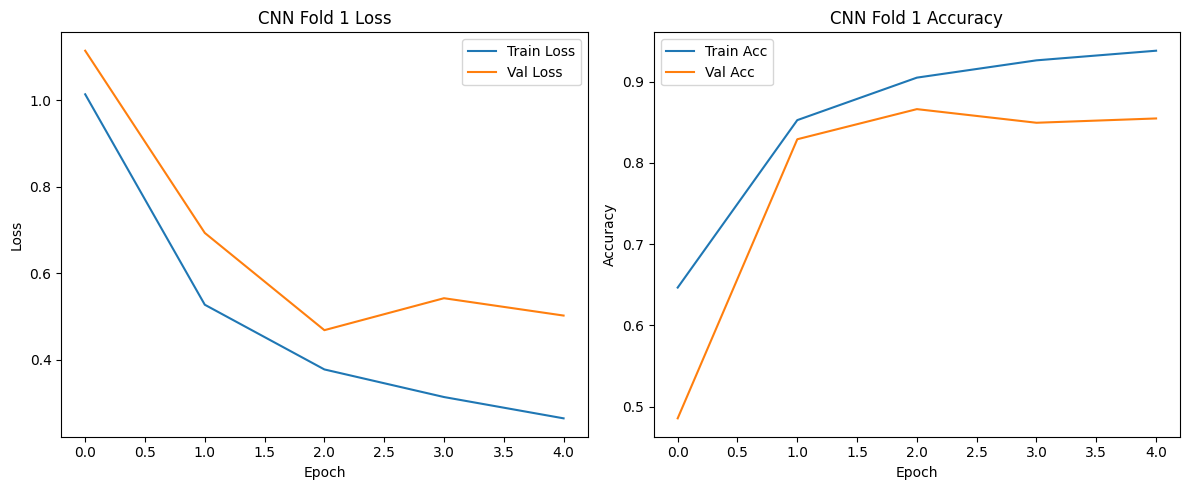

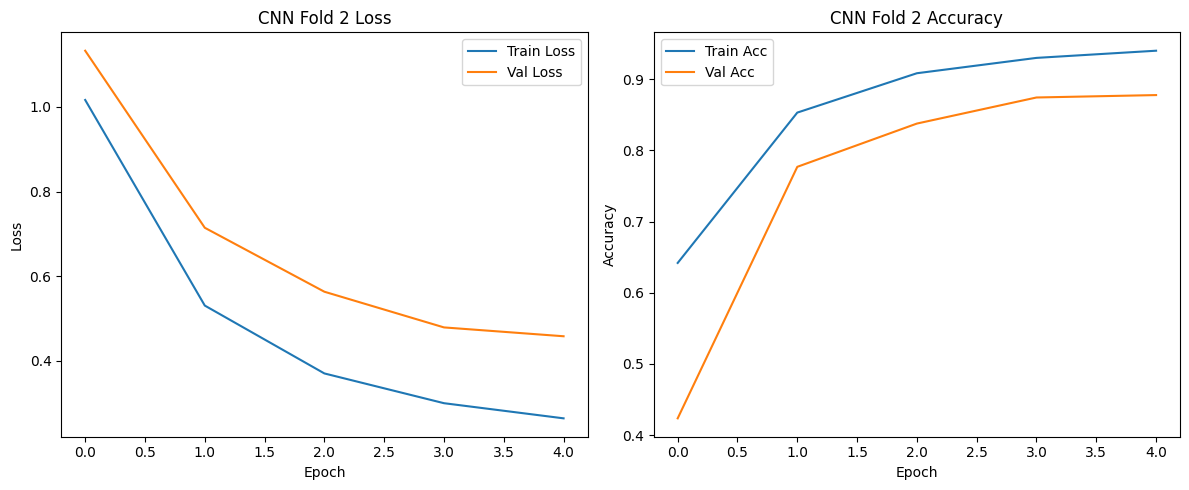

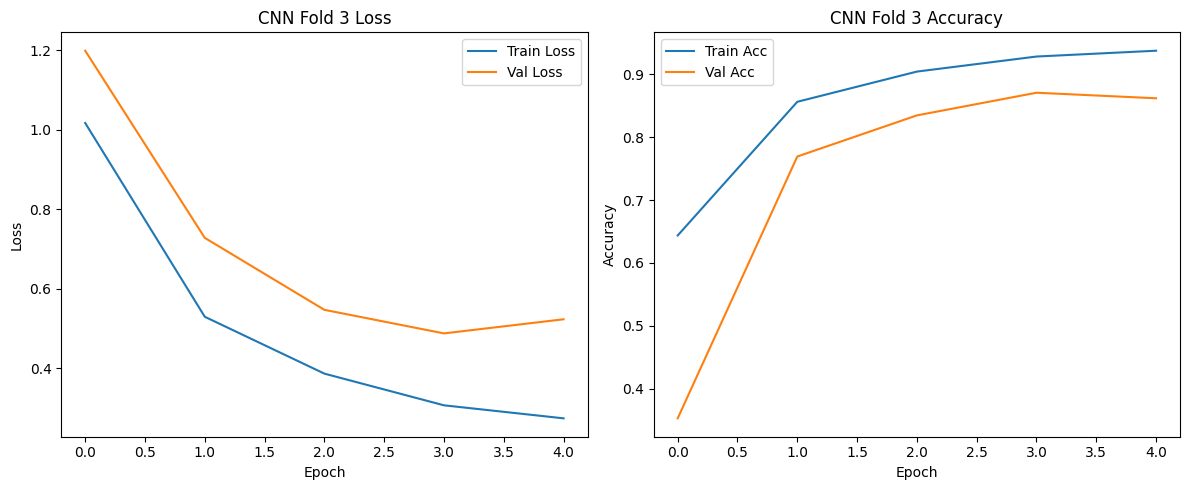

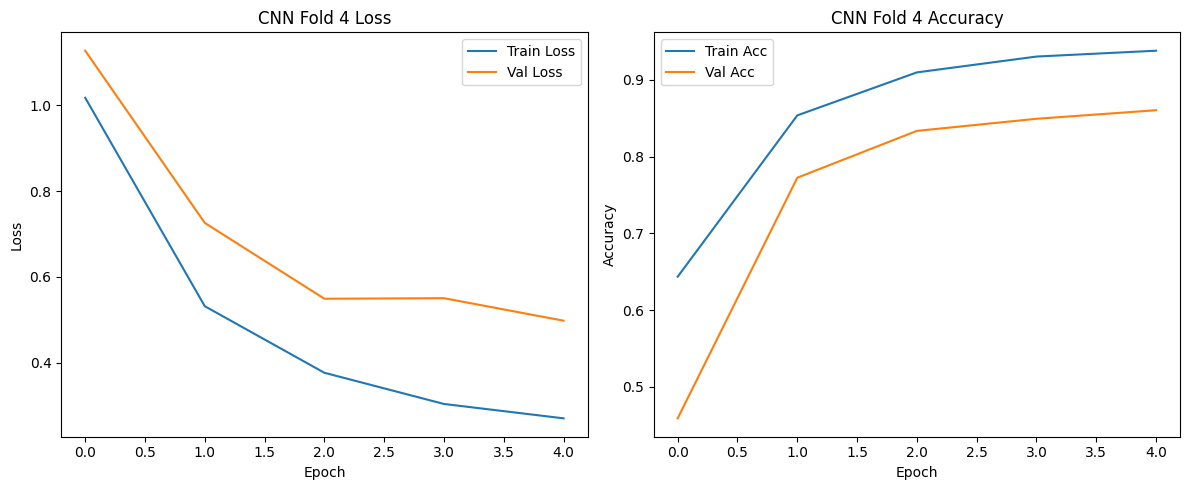

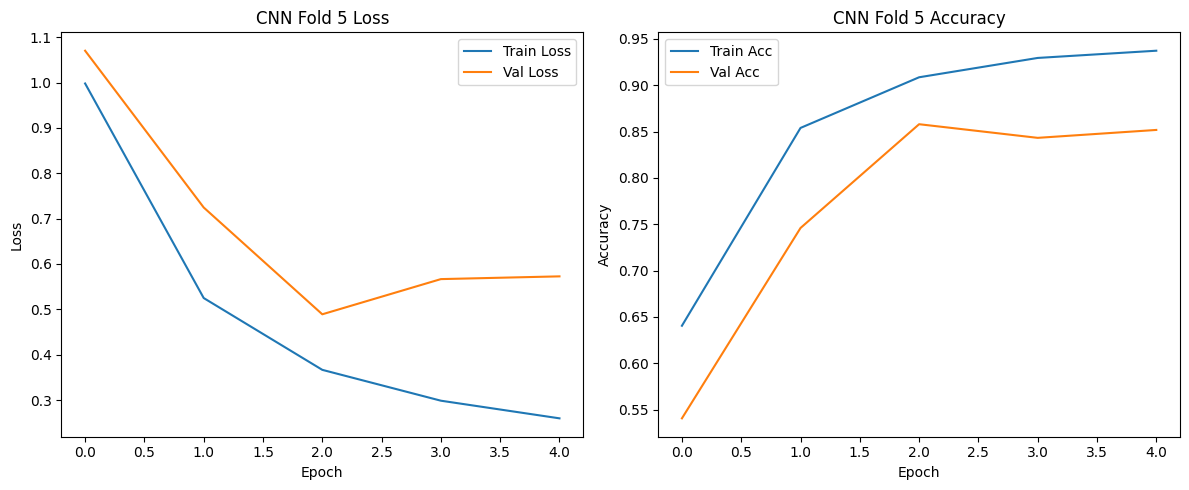

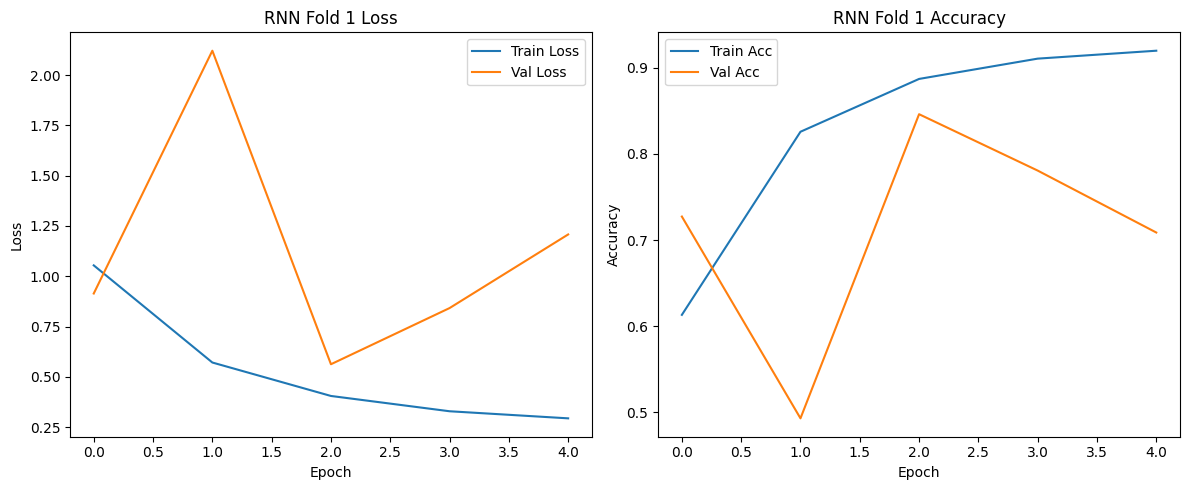

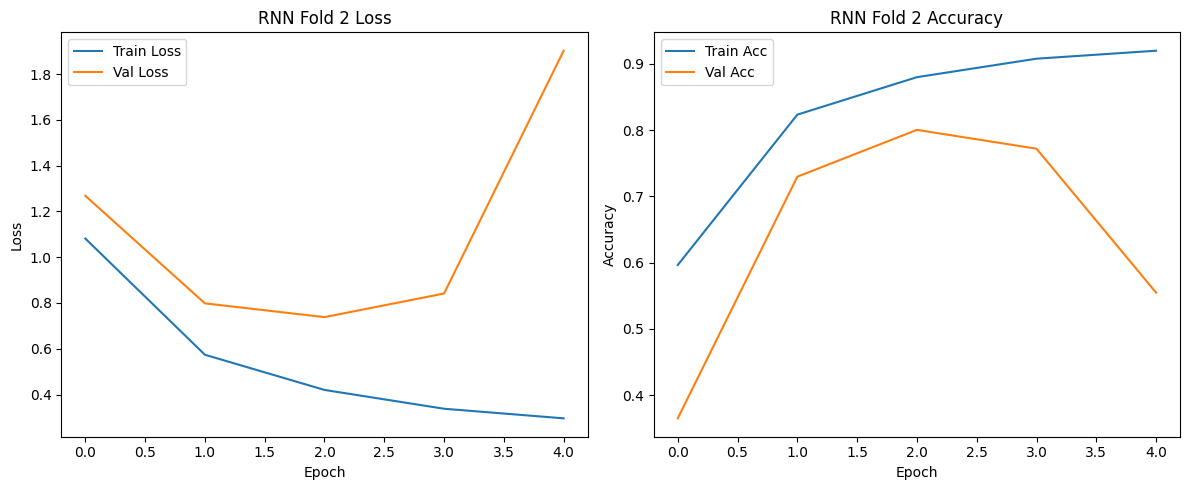

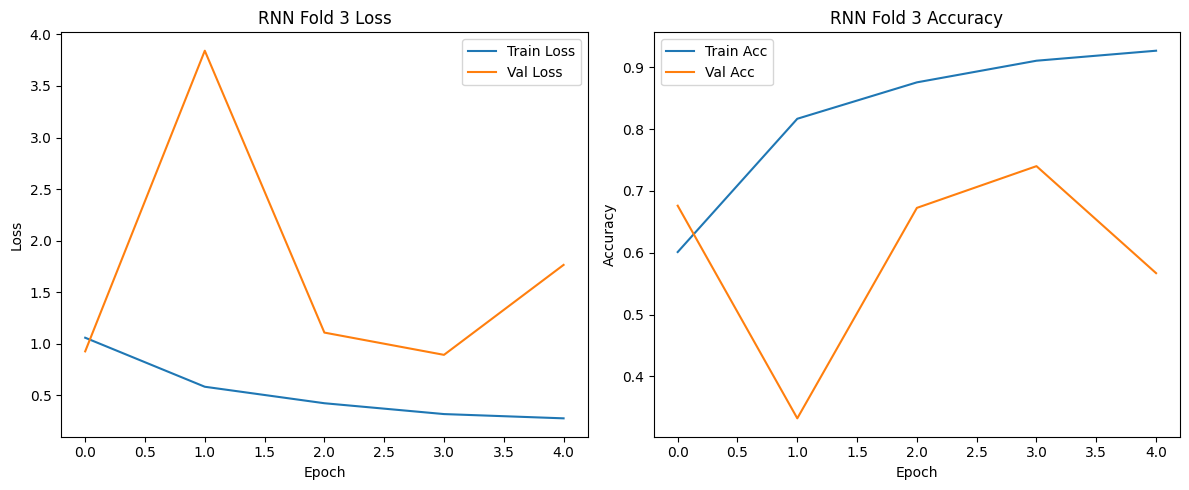

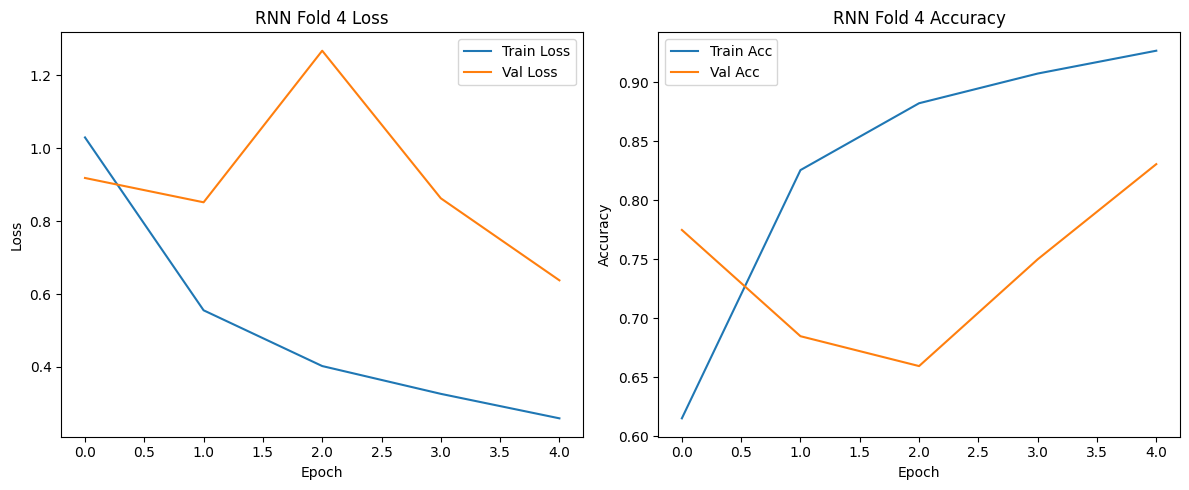

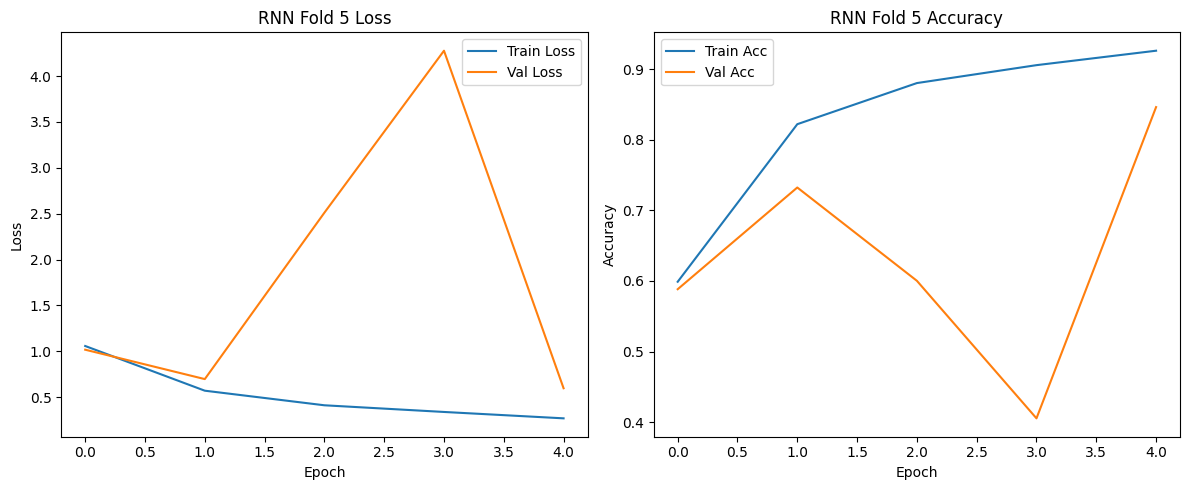

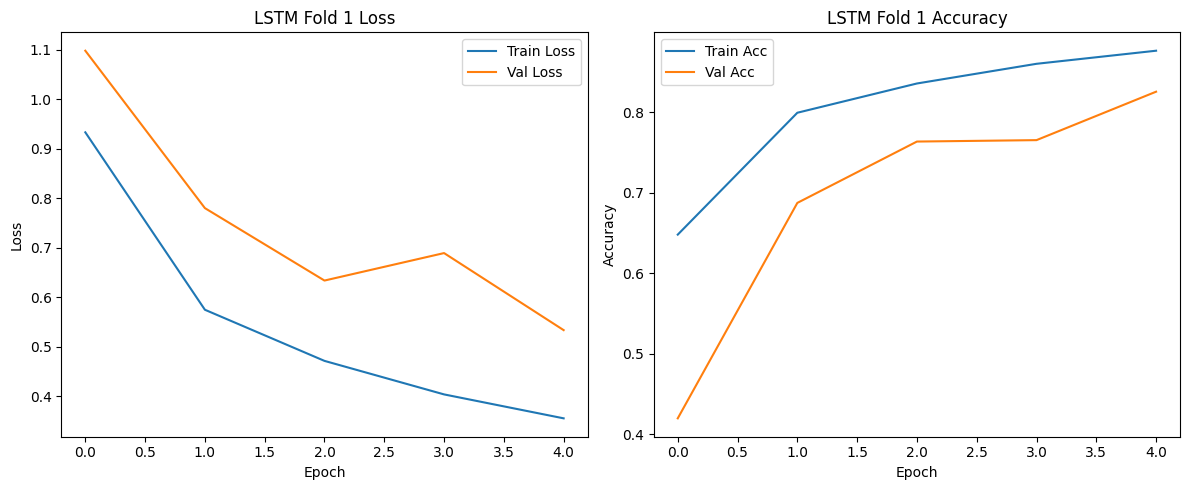

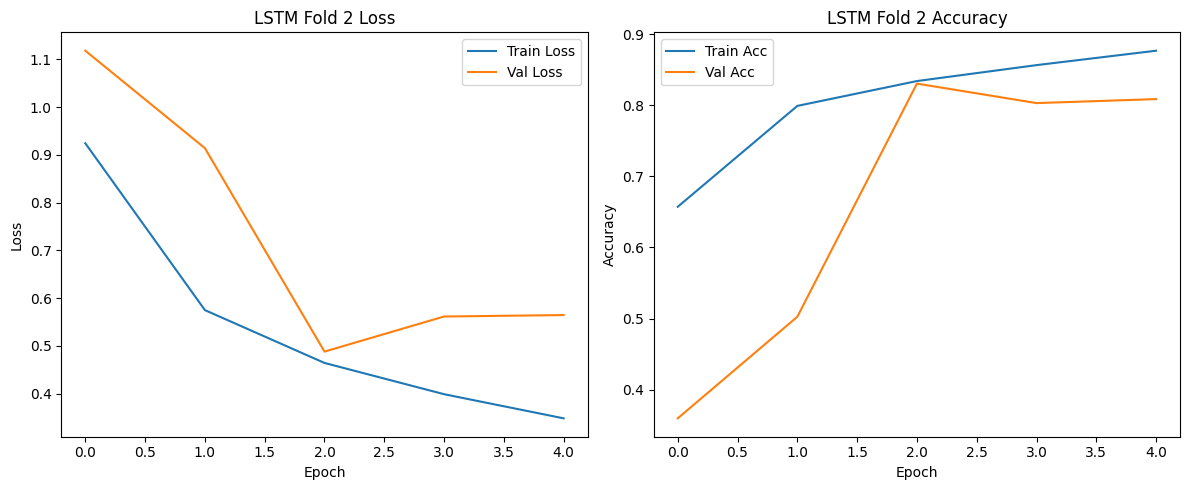

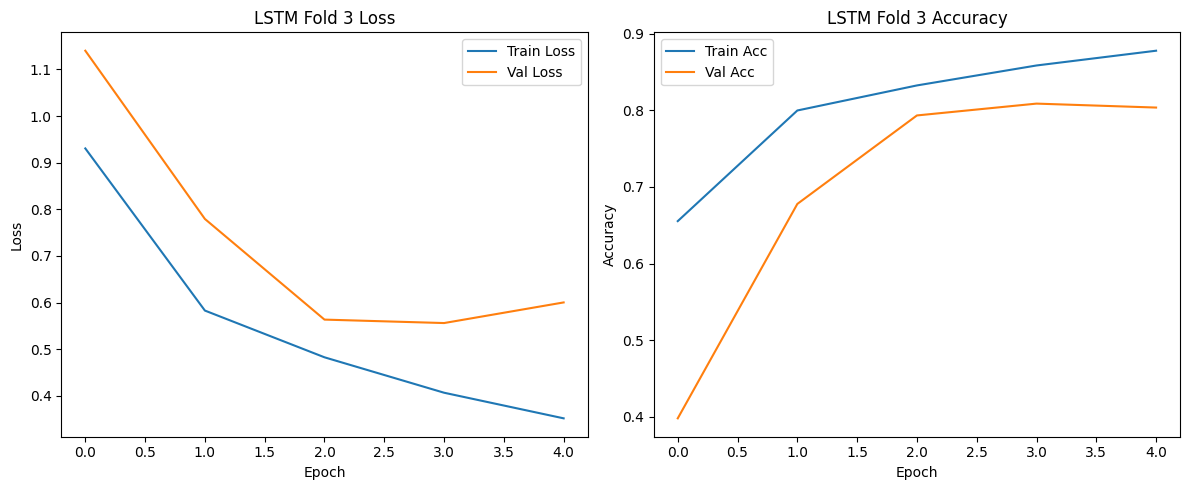

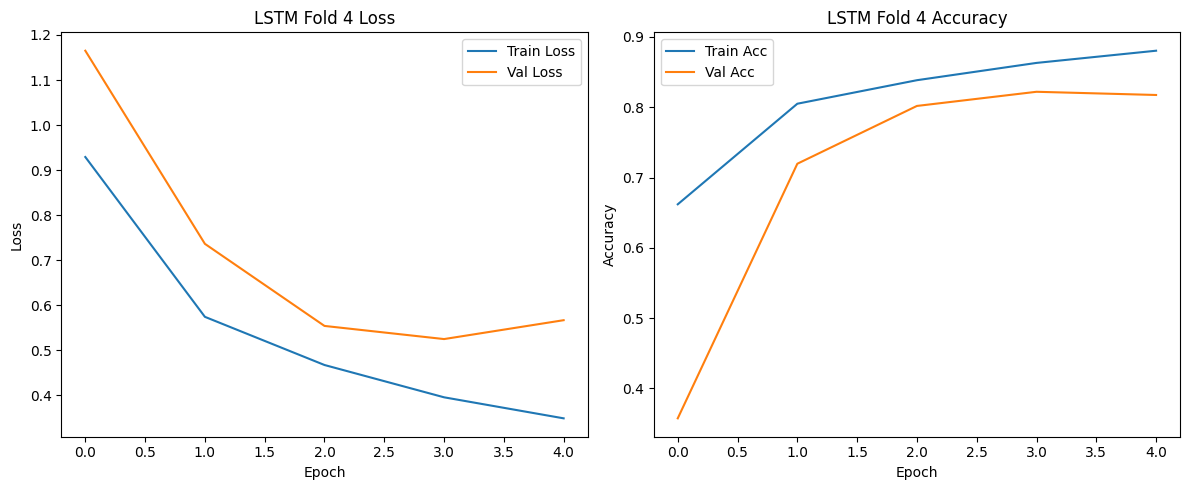

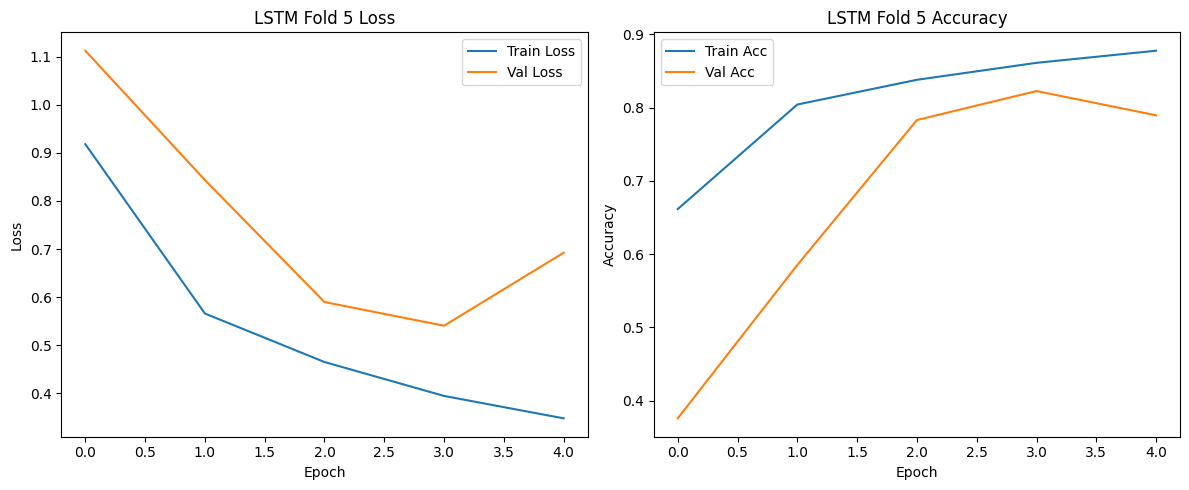

In [31]:
# Plot training/validation loss and accuracy curves
import matplotlib.pyplot as plt
for name in train_histories:
    for fold_idx, history in enumerate(train_histories[name]):
        plt.figure(figsize=(12, 5))
        # Loss
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f'{name} Fold {fold_idx+1} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        # Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Train Acc')
        plt.plot(history.history['val_accuracy'], label='Val Acc')
        plt.title(f'{name} Fold {fold_idx+1} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.show()

In [32]:
# 6. Average metrics and select best model
import statistics
summary = {}
for name in results:
    avg_metrics = {metric: statistics.mean([fold[metric] for fold in results[name]]) for metric in results[name][0]}
    summary[name] = avg_metrics
    print(f"\n{name} Average Metrics:")
    for metric, value in avg_metrics.items():
        print(f"{metric}: {value:.4f}")


CNN Average Metrics:
accuracy: 0.8666
precision: 0.8687
recall: 0.8666
f1: 0.8665
mcc: 0.8009
mse: 0.1771
rmse: 0.4205
r2: 0.7345

RNN Average Metrics:
accuracy: 0.8127
precision: 0.8315
recall: 0.8127
f1: 0.8116
mcc: 0.7272
mse: 0.2843
rmse: 0.5275
r2: 0.5735

LSTM Average Metrics:
accuracy: 0.8218
precision: 0.8281
recall: 0.8218
f1: 0.8208
mcc: 0.7363
mse: 0.2445
rmse: 0.4943
r2: 0.6333


In [33]:
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'mcc', 'mse', 'rmse', 'r2']
plot_data = []
for name in results:
    for fold_idx, fold in enumerate(results[name]):
        fold_data = {'Model': name, 'Fold': f'Fold {fold_idx + 1}'}
        fold_data.update(fold)
        plot_data.append(fold_data)
plot_df = pd.DataFrame(plot_data)

In [34]:
for metric in metrics_to_plot:
    if metric in ['mse', 'rmse']:  # For these, lower is better
        best = min(summary, key=lambda x: summary[x][metric])
    else:  # For others, higher is better
        best = max(summary, key=lambda x: summary[x][metric])
    print(f"For {metric}, the winner is {best} (score: {summary[best][metric]:.4f})")


print(f"\nOverall Best Model: {best}")
print(f"This is because {best} achieved the best average scores across most metrics (accuracy, precision, recall, f1, mcc, mse, rmse, r2) \ncompared to the other two, indicating it generalizes better on this sentiment classification task.")


For accuracy, the winner is CNN (score: 0.8666)
For precision, the winner is CNN (score: 0.8687)
For recall, the winner is CNN (score: 0.8666)
For f1, the winner is CNN (score: 0.8665)
For mcc, the winner is CNN (score: 0.8009)
For mse, the winner is CNN (score: 0.1771)
For rmse, the winner is CNN (score: 0.4205)
For r2, the winner is CNN (score: 0.7345)

Overall Best Model: CNN
This is because CNN achieved the best average scores across most metrics (accuracy, precision, recall, f1, mcc, mse, rmse, r2) 
compared to the other two, indicating it generalizes better on this sentiment classification task.


In [36]:
# 🚀 Final training after cross-validation
# Use sparse labels (y) + sparse_categorical_crossentropy for efficiency

# CNN
cnn_model = build_cnn(maxlen, vocab_size, num_classes)
cnn_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)
cnn_model.fit(X, y, epochs=5, batch_size=32, verbose=1)
cnn_tokenizer = tokenizer  # keep tokenizer for later inference

# RNN
rnn_model = build_rnn(maxlen, vocab_size, num_classes)
rnn_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)
rnn_model.fit(X, y, epochs=5, batch_size=32, verbose=1)
rnn_tokenizer = tokenizer

# LSTM
lstm_model = build_lstm(maxlen, vocab_size, num_classes)
lstm_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)
lstm_model.fit(X, y, epochs=5, batch_size=32, verbose=1)
lstm_tokenizer = tokenizer


Epoch 1/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6151 - loss: 1.0018
Epoch 2/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8670 - loss: 0.4530
Epoch 3/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9030 - loss: 0.3408
Epoch 4/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9254 - loss: 0.2750
Epoch 5/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9294 - loss: 0.2584
Epoch 1/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.5905 - loss: 1.0112
Epoch 2/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8444 - loss: 0.4755
Epoch 3/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8897 - loss: 0.3450
Epoch 4/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8994 - loss: 0.3005
Epoch 5/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9118 - loss: 0.2607
Epoch 1/5
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.6355 - loss: 0.9008
Epoch 2/5
1063/1063 ━━━━━━━━━━━━━━

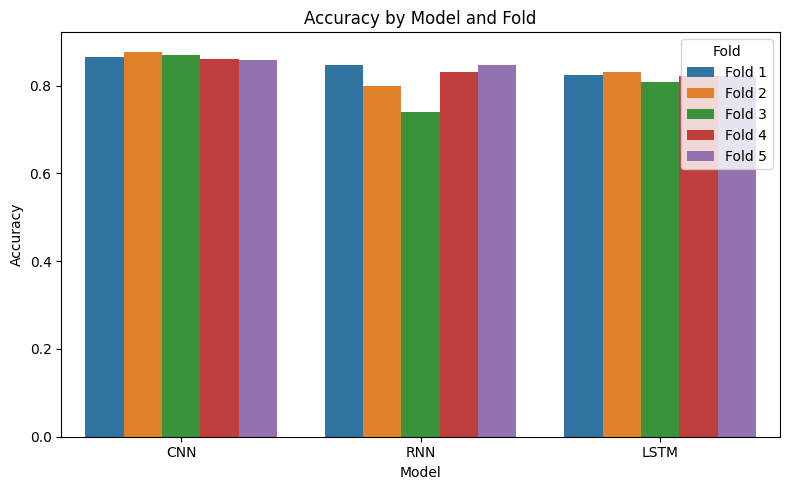

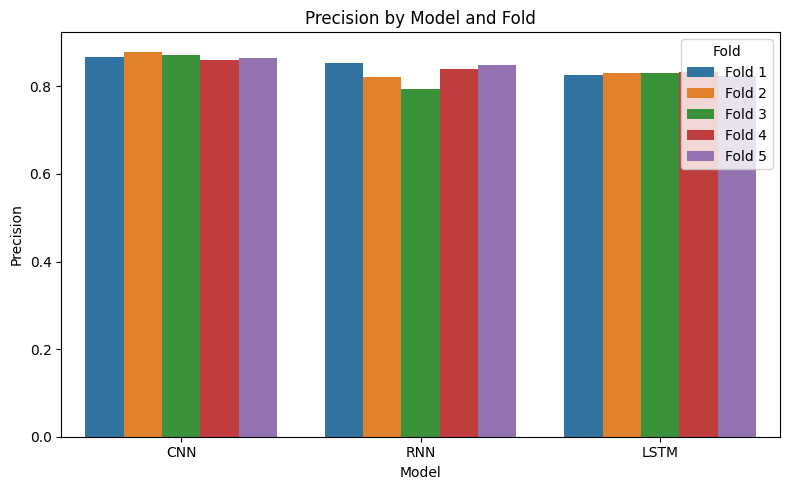

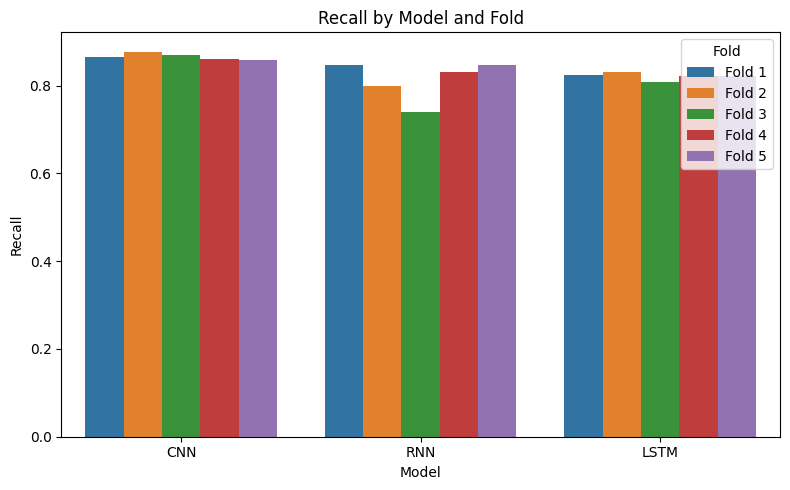

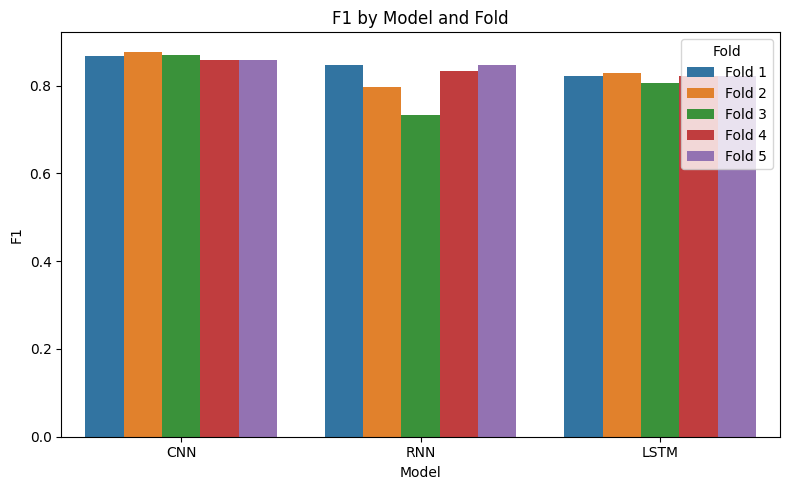

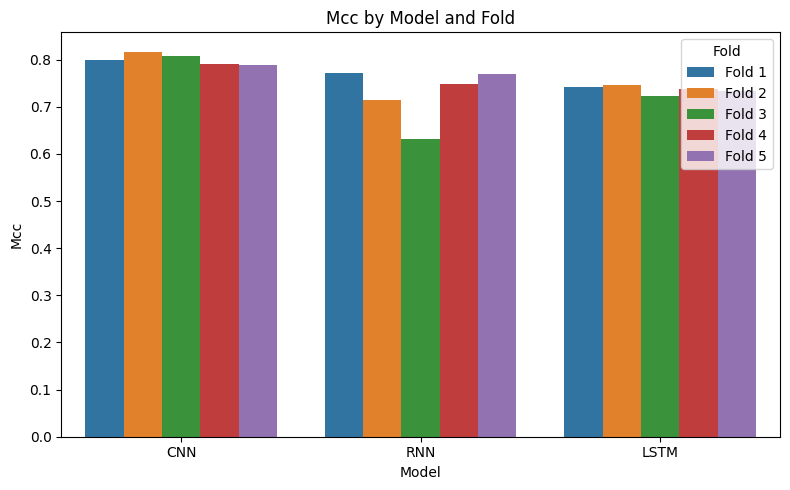

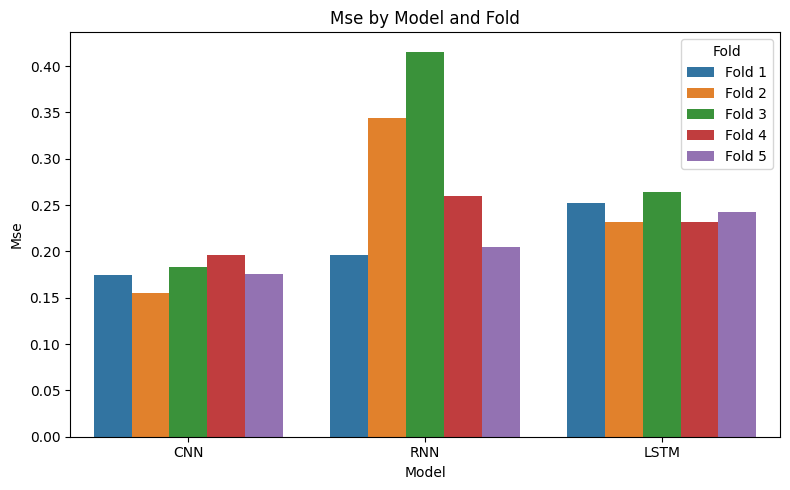

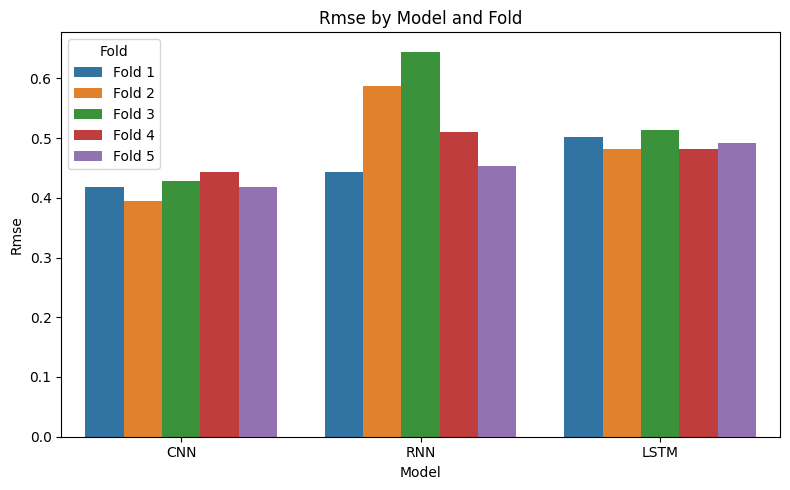

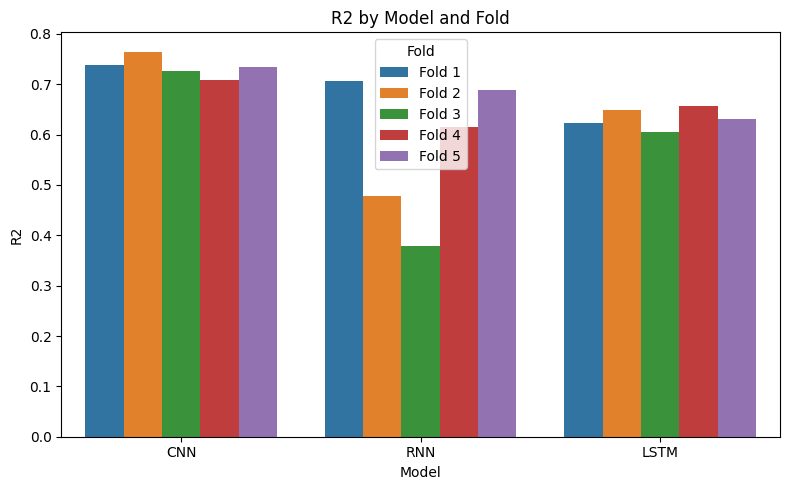

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

for metric in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    sns.barplot(data=plot_df, x='Model', y=metric, hue='Fold')
    plt.title(f'{metric.capitalize()} by Model and Fold')
    plt.ylabel(metric.capitalize())
    plt.tight_layout()
    plt.show()

In [ ]:
# import pickle

# models_dict = {'CNN': [cnn_fold1, cnn_fold2], ...}
# tokenizers_dict = {'CNN': [cnn_tokenizer_fold1, cnn_tokenizer_fold2], ...}

# for name in ['CNN', 'RNN', 'LSTM']:
#     for fold_idx, model in enumerate(models_dict[name]):
#         model_filename = f'{name.lower()}_fold{fold_idx+1}_model.h5'
#         tokenizer_filename = f'{name.lower()}_fold{fold_idx+1}_tokenizer.pkl'
#         # Save model
#         model.save(model_filename)
#         # Save corresponding tokenizer
#         with open(tokenizer_filename, 'wb') as f:
#             pickle.dump(tokenizers_dict[name][fold_idx], f)
#         print(f'Saved {model_filename} and {tokenizer_filename}')

In [38]:
import pickle

# Save CNN model and tokenizer
cnn_model.save('cnn_model.keras')
with open('cnn_tokenizer.obj', 'wb') as f:
    pickle.dump(cnn_tokenizer, f)

# # Save RNN model and tokenizer
# rnn_model.save('rnn_model.keras')
# with open('rnn_tokenizer.obj', 'wb') as f:
#     pickle.dump(rnn_tokenizer, f)

# # Save LSTM model and tokenizer
# lstm_model.save('lstm_model.keras')
# with open('lstm_tokenizer.obj', 'wb') as f:
#     pickle.dump(lstm_tokenizer, f)

# print('Saved CNN, RNN, and LSTM models as .keras files and their tokenizers as .obj files.')